In [1]:
import os
import time
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.autograd as autograd

from utils.multiprocessing_env import SubprocVecEnv
from utils.minipacman import MiniPacman
from utils.environment_model import EnvModel
from utils.actor_critic import ActorCritic, RolloutStorage

import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
from IPython import display


DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
pixels = (
    (0.0, 1.0, 0.0), 
    (0.0, 1.0, 1.0),
    (0.0, 0.0, 1.0),
    (1.0, 1.0, 1.0),
    (1.0, 1.0, 0.0), 
    (0.0, 0.0, 0.0),
    (1.0, 0.0, 0.0)
)
pixel_to_onehot = {pix:i for i, pix in enumerate(pixels)} 
num_pixels = len(pixels)

task_rewards = {
    "regular": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    "avoid":   [0.1, -0.1, -5, -10, -20],
    "hunt":    [0, 1, 10, -20],
    "ambush":  [0, -0.1, 10, -20],
    "rush":    [0, -0.1, 9.9]
}
reward_to_onehot = {mode: {reward:i for i, reward in enumerate(task_rewards[mode])} for mode in task_rewards.keys()}

def pix_to_target(next_states):
    target = []
    for pixel in next_states.transpose(0, 2, 3, 1).reshape(-1, 3):
        target.append(pixel_to_onehot[tuple([np.round(pixel[0]), np.round(pixel[1]), np.round(pixel[2])])])
    return target

def target_to_pix(imagined_states):
    pixels = []
    to_pixel = {value: key for key, value in pixel_to_onehot.items()}
    for target in imagined_states:
        pixels.append(list(to_pixel[target]))
    return np.array(pixels)

def rewards_to_target(mode, rewards):
    target = []
    for reward in rewards:
        target.append(reward_to_onehot[mode][reward])
    return target
    
def displayImage(image, step, reward):
    s = str(step) + " " + str(reward)
    plt.title(s)
    plt.imshow(image)
    plt.show()

In [3]:
class RolloutEncoder(nn.Module):
    def __init__(self, in_shape, num_rewards, hidden_size):
        super(RolloutEncoder, self).__init__()
        
        self.in_shape = in_shape
        
        self.features = nn.Sequential(
            nn.Conv2d(in_shape[0], 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=2),
            nn.ReLU(),
        )
        
        self.gru = nn.GRU(self.feature_size() + num_rewards, hidden_size)
        
    def forward(self, state, reward):
        num_steps  = state.size(0)
        batch_size = state.size(1)
        
        state = state.view(-1, *self.in_shape)
        state = self.features(state)
        state = state.view(num_steps, batch_size, -1)
        rnn_input = torch.cat([state, reward], 2)
        _, hidden = self.gru(rnn_input)
        return hidden.squeeze(0)
    
    
    def feature_size(self):
        return self.features(torch.zeros(1, *self.in_shape)).view(1, -1).size(1)

In [4]:
class ImaginationCore(object):
    def __init__(self, num_rolouts, in_shape, num_actions, num_rewards, env_model, distil_policy, full_rollout=True):
        self.num_rolouts  = num_rolouts
        self.in_shape      = in_shape
        self.num_actions   = num_actions
        self.num_rewards   = num_rewards
        self.env_model     = env_model
        self.distil_policy = distil_policy
        self.full_rollout  = full_rollout
        
    def __call__(self, state):
        state      = state.cpu()
        batch_size = state.size(0)

        rollout_states  = []
        rollout_rewards = []

        if self.full_rollout:
            state = state.unsqueeze(0).repeat(self.num_actions, 1, 1, 1, 1).view(-1, *self.in_shape)
            action = torch.LongTensor([[i] for i in range(self.num_actions)]*batch_size)
            action = action.view(-1)
            rollout_batch_size = batch_size * self.num_actions
        else:
            with torch.no_grad():
                action = self.distil_policy.act(state)
                
            action = action.data.cpu()
            rollout_batch_size = batch_size

        for step in range(self.num_rolouts):
            onehot_action = torch.zeros(rollout_batch_size, self.num_actions, *self.in_shape[1:])
            onehot_action[range(rollout_batch_size), action] = 1
            inputs = torch.cat([state, onehot_action], 1)

            with torch.no_grad():
                imagined_state, imagined_reward = self.env_model(inputs.to(DEVICE))

            imagined_state  = F.softmax(imagined_state, dim=-1).max(1)[1].data.cpu()
            imagined_reward = F.softmax(imagined_reward, dim=-1).max(1)[1].data.cpu()
            imagined_state = target_to_pix(imagined_state.numpy())
            imagined_state = torch.FloatTensor(imagined_state).view(rollout_batch_size, *self.in_shape)

            onehot_reward = torch.zeros(rollout_batch_size, self.num_rewards)
            onehot_reward[range(rollout_batch_size), imagined_reward] = 1

            rollout_states.append(imagined_state.unsqueeze(0))
            rollout_rewards.append(onehot_reward.unsqueeze(0))

            state  = imagined_state
            with torch.no_grad():
                action = self.distil_policy.act(state.to(DEVICE))
            
            action = action.data.cpu()
        
        return torch.cat(rollout_states).to(DEVICE), torch.cat(rollout_rewards).to(DEVICE)

In [5]:
class I2A(nn.Module):
    def __init__(self, in_shape, num_actions, num_rewards, hidden_size, imagination, full_rollout=True):
        super(I2A, self).__init__()
        
        self.in_shape      = in_shape
        self.num_actions   = num_actions
        self.num_rewards   = num_rewards
        
        self.imagination = imagination
        
        self.features = nn.Sequential(
            nn.Conv2d(in_shape[0], 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=2),
            nn.ReLU(),
        )
        
        self.encoder = RolloutEncoder(in_shape, num_rewards, hidden_size)
        
        if full_rollout:
            self.fc = nn.Sequential(
                nn.Linear(self.feature_size() + num_actions * hidden_size, 256),
                nn.ReLU(),
            )
        else:
            self.fc = nn.Sequential(
                nn.Linear(self.feature_size() + hidden_size, 256),
                nn.ReLU(),
            )
        
        self.critic  = nn.Linear(256, 1)
        self.actor   = nn.Linear(256, num_actions)
        
    def forward(self, state):
        batch_size = state.size(0)
        imagined_state, imagined_reward = self.imagination(state.data)
        hidden = self.encoder(imagined_state, imagined_reward)
        hidden = hidden.view(batch_size, -1)
        
        state = self.features(state)
        state = state.view(state.size(0), -1)
        
        x = torch.cat([state, hidden], 1)
        x = self.fc(x)
        
        logit = self.actor(x)
        value = self.critic(x)
        
        return logit, value
    
    
    def act(self, x, deterministic=False):
        logit, _ = self.forward(x)
        probs = F.softmax(logit, dim=-1)
        
        if deterministic:
            action = probs.max(1)[1]
        else:
            action = probs.multinomial(1)
        
        return action
    
    def evaluate_actions(self, x, action):
        logit, value = self.forward(x)
        
        probs     = F.softmax(logit, dim=-1)
        log_probs = F.log_softmax(logit, dim=-1)
        
        action_log_probs = log_probs.gather(1, action)
        entropy = -(probs * log_probs).sum(1).mean()
        
        return logit, action_log_probs, value, entropy
    
    
    def feature_size(self):
        return self.features(torch.zeros(1, *self.in_shape)).view(1, -1).size(1)

# Training

In [ ]:
mode = "regular"
num_envs = 16

def make_env():
    def _thunk():
        env = MiniPacman(mode, 1000)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

state_shape = envs.observation_space.shape
num_actions = envs.action_space.n
num_rewards = len(task_rewards[mode])

In [ ]:
full_rollout = True

In [ ]:
env_model     = EnvModel(envs.observation_space.shape, envs.action_space.n, num_pixels, num_rewards)
env_model.load_state_dict(torch.load("env_model"))

distil_policy = ActorCritic(envs.observation_space.shape, envs.action_space.n)
distil_optimizer = optim.Adam(distil_policy.parameters())

imagination = ImaginationCore(10, state_shape, num_actions, num_rewards, env_model, distil_policy, full_rollout=full_rollout)

actor_critic = I2A(state_shape, num_actions, num_rewards, 256, imagination, full_rollout=full_rollout)
#rmsprop hyperparams:
lr    = 7e-4
eps   = 1e-5
alpha = 0.99
optimizer = optim.RMSprop(actor_critic.parameters(), lr, eps=eps, alpha=alpha)


env_model.to(DEVICE)
distil_policy.to(DEVICE)
actor_critic.to(DEVICE)

display.clear_output()

In [ ]:
gamma = 0.99
entropy_coef = 0.01
value_loss_coef = 0.5
max_grad_norm = 0.5
num_steps = 5
num_frames = int(1e4)

rollout = RolloutStorage(num_steps, num_envs, envs.observation_space.shape)
rollout.to(DEVICE)

all_rewards = []
all_losses  = []

In [ ]:
state = envs.reset()
current_state = torch.FloatTensor(np.float32(state))

rollout.states[0].copy_(current_state)

episode_rewards = torch.zeros(num_envs, 1)
final_rewards   = torch.zeros(num_envs, 1)

for i_update in range(num_frames):

    for step in range(num_steps):
        current_state = current_state.to(DEVICE)
        action = actor_critic.act(current_state)

        next_state, reward, done, _ = envs.step(action.squeeze(1).cpu().data.numpy())

        reward = torch.FloatTensor(reward).unsqueeze(1)
        episode_rewards += reward
        masks = torch.FloatTensor(1-np.array(done)).unsqueeze(1)
        final_rewards *= masks
        final_rewards += (1-masks) * episode_rewards
        episode_rewards *= masks

        masks = masks.to(DEVICE)

        current_state = torch.FloatTensor(np.float32(next_state))
        rollout.insert(step, current_state, action.data, reward, masks)

    with torch.no_grad():
        _, next_value = actor_critic(rollout.states[-1])
    
    next_value = next_value.data

    returns = rollout.compute_returns(next_value, gamma)

    logit, action_log_probs, values, entropy = actor_critic.evaluate_actions(
        rollout.states[:-1].detach().view(-1, *state_shape),
        rollout.actions.detach().view(-1, 1)
    )
    
    distil_logit, _, _, _ = distil_policy.evaluate_actions(
        rollout.states[:-1].detach().view(-1, *state_shape),
        rollout.actions.detach().view(-1, 1)
    )
        
    distil_loss = 0.01 * (F.softmax(logit, dim=-1).detach() * F.log_softmax(distil_logit, dim=-1)).sum(1).mean()

    values = values.view(num_steps, num_envs, 1)
    action_log_probs = action_log_probs.view(num_steps, num_envs, 1)
    advantages = returns - values

    value_loss = advantages.pow(2).mean()
    action_loss = -(advantages.detach() * action_log_probs).mean()

    optimizer.zero_grad()
    loss = value_loss * value_loss_coef + action_loss - entropy * entropy_coef
    loss.backward()
    nn.utils.clip_grad_norm_(actor_critic.parameters(), max_grad_norm)
    optimizer.step()
    
    distil_optimizer.zero_grad()
    distil_loss.backward()
    optimizer.step()
    
    if i_update % 100 == 0:
        all_rewards.append(final_rewards.mean())
        all_losses.append(loss.data)
        
        display.clear_output(True)
        plt.figure(figsize=(20,5))
        plt.subplot(131)
        plt.title(f"epoch {i_update}. reward: {np.mean(all_rewards[-10:])}")
        plt.plot(all_rewards)
        plt.subplot(132)
        plt.title(f"loss {all_losses[-1].item()}")
        plt.plot(all_losses)
        plt.show()
        
    rollout.after_update()

# Testing

In [7]:
mode = "regular"
num_envs = 16

def make_env():
    def _thunk():
        env = MiniPacman(mode, 1000)
        return env

    return _thunk

envs = [make_env() for i in range(num_envs)]
envs = SubprocVecEnv(envs)

state_shape = envs.observation_space.shape
num_actions = envs.action_space.n
num_rewards = len(task_rewards[mode])


env_model     = EnvModel(envs.observation_space.shape, envs.action_space.n, num_pixels, num_rewards)
env_model.load_state_dict(torch.load("training/environment_model/env_model", map_location=DEVICE))

distil_policy = ActorCritic(envs.observation_space.shape, envs.action_space.n)
distil_optimizer = optim.Adam(distil_policy.parameters())

In [8]:
checkpoint = torch.load(os.path.join("training/imagination_augmented_agents_rollout_5", "I2A_checkpoint"), map_location=DEVICE)
rollout = checkpoint['rollout']
imagination = checkpoint['imagination']

actor_critic = I2A(state_shape, num_actions, num_rewards, 256, imagination, full_rollout=True)
actor_critic.load_state_dict(checkpoint['actor_critic_state_dict'])
actor_critic.to(DEVICE)

I2A(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
    (3): ReLU()
  )
  (encoder): RolloutEncoder(
    (features): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2))
      (3): ReLU()
    )
    (gru): GRU(778, 256)
  )
  (fc): Sequential(
    (0): Linear(in_features=2048, out_features=256, bias=True)
    (1): ReLU()
  )
  (critic): Linear(in_features=256, out_features=1, bias=True)
  (actor): Linear(in_features=256, out_features=5, bias=True)
)

steps: 501, reward: 300


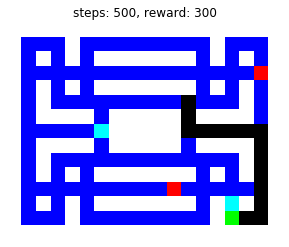

In [9]:
env = MiniPacman(mode, 1000)
state = env.reset()
done = False
total_reward = 0
step = 1

while not done and step <= 500:
    current_state = torch.FloatTensor(state).unsqueeze(0).to(DEVICE)
    action = actor_critic.act(current_state)
    next_state, reward, done, _ = env.step(action.data[0, 0])
    total_reward += reward
    state = next_state
    
    plt.imshow(state.transpose([1, 2, 0]))
    plt.axis('off')
    plt.title(f"steps: {step}, reward: {total_reward}")
    
    display.display(plt.gcf())
    display.clear_output(wait=True)
    time.sleep(0.1)
    
    step += 1

print(f"steps: {step}, reward: {total_reward}")